In [1]:
!pip install xgboost

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("📊 Loading POWERGRID Dataset...")
# Load the dataset from your provided data
df = pd.read_csv('powergrid_demand_forecast_dataset.csv')
print(f"✅ Dataset loaded successfully with {len(df)} rows and {len(df.columns)} columns")

# Display basic information about the dataset with data types
print("\n🔍 Dataset Overview:")
print(f"Shape: {df.shape}")
print(f"\n📋 Columns and Data Types:")
print(df.dtypes)
print(f"\n❓ Missing Values:\n{df.isnull().sum()}")

# Check sample data to identify issues
print("\n👀 First 10 rows of the dataset:")
print(df.head(10))

# Check unique values in categorical columns
print("\n🔍 Checking categorical columns:")
print(f"Month unique values: {sorted(df['Month'].unique())}")
print(f"Month data type: {df['Month'].dtype}")

📊 Loading POWERGRID Dataset...
✅ Dataset loaded successfully with 500 rows and 10 columns

🔍 Dataset Overview:
Shape: (500, 10)

📋 Columns and Data Types:
Project_ID               object
State                    object
Tower_Type               object
Substation_Type          object
Budget_Cr               float64
Tax_Rate                  int64
Month                    object
Geographic_Risk           int64
Material_Demand_Tons      int64
Year                      int64
dtype: object

❓ Missing Values:
Project_ID              0
State                   0
Tower_Type              0
Substation_Type         0
Budget_Cr               0
Tax_Rate                0
Month                   0
Geographic_Risk         0
Material_Demand_Tons    0
Year                    0
dtype: int64

👀 First 10 rows of the dataset:
  Project_ID           State Tower_Type Substation_Type  Budget_Cr  Tax_Rate  \
0       P001           Assam     Type-B           400kV      74.78        12   
1       P002  Madhya Prade

In [13]:
# Fix data type issues
print("\n🔧 Fixing Data Type Issues...")

# Convert Month to numeric - handle string months if they exist
if df['Month'].dtype == 'object':
    print("Converting Month from string to numeric...")
    month_map = {
        'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
        'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
    }
    df['Month'] = df['Month'].map(month_map)
    # Fill any NaN values with the original value (in case some are already numeric)
    df['Month'] = df['Month'].fillna(pd.to_numeric(df['Month'], errors='coerce'))
else:
    # Ensure it's numeric
    df['Month'] = pd.to_numeric(df['Month'], errors='coerce')

# Ensure all numeric columns are properly converted
numeric_columns = ['Budget_Cr', 'Tax_Rate', 'Geographic_Risk', 'Material_Demand_Tons', 'Year']
for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop any rows with NaN values that resulted from conversion
initial_count = len(df)
df = df.dropna()
final_count = len(df)
print(f"Removed {initial_count - final_count} rows with invalid data")

print("\n✅ Data types after cleaning:")
print(df.dtypes)
print(f"\n📊 Dataset now has {len(df)} rows")

# Display basic statistics
print("\n📈 Basic Statistics:")
print(df.describe())


🔧 Fixing Data Type Issues...
Converting Month from string to numeric...
Removed 0 rows with invalid data

✅ Data types after cleaning:
Project_ID               object
State                    object
Tower_Type               object
Substation_Type          object
Budget_Cr               float64
Tax_Rate                  int64
Month                     int64
Geographic_Risk           int64
Material_Demand_Tons      int64
Year                      int64
dtype: object

📊 Dataset now has 500 rows

📈 Basic Statistics:
        Budget_Cr    Tax_Rate       Month  Geographic_Risk  \
count  500.000000  500.000000  500.000000       500.000000   
mean    81.520520   14.736000    6.518000         5.972000   
std     23.910778    2.991354    3.467235         2.011793   
min     40.050000   12.000000    1.000000         3.000000   
25%     60.507500   12.000000    3.000000         4.000000   
50%     82.035000   12.000000    6.000000         6.000000   
75%    103.457500   18.000000   10.000000      


🏢 Unique Values Analysis:
Projects: 500
States: 10
Tower Types: ['Type-B' 'Type-C' 'Type-A' 'Type-D']
Substation Types: ['400kV' '132kV' '220kV']
Months: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Years: [2024]

📊 Material Demand Statistics:
Min Demand: 292 tons
Max Demand: 1922 tons
Average Demand: 1050.67 tons
Median Demand: 1045.50 tons


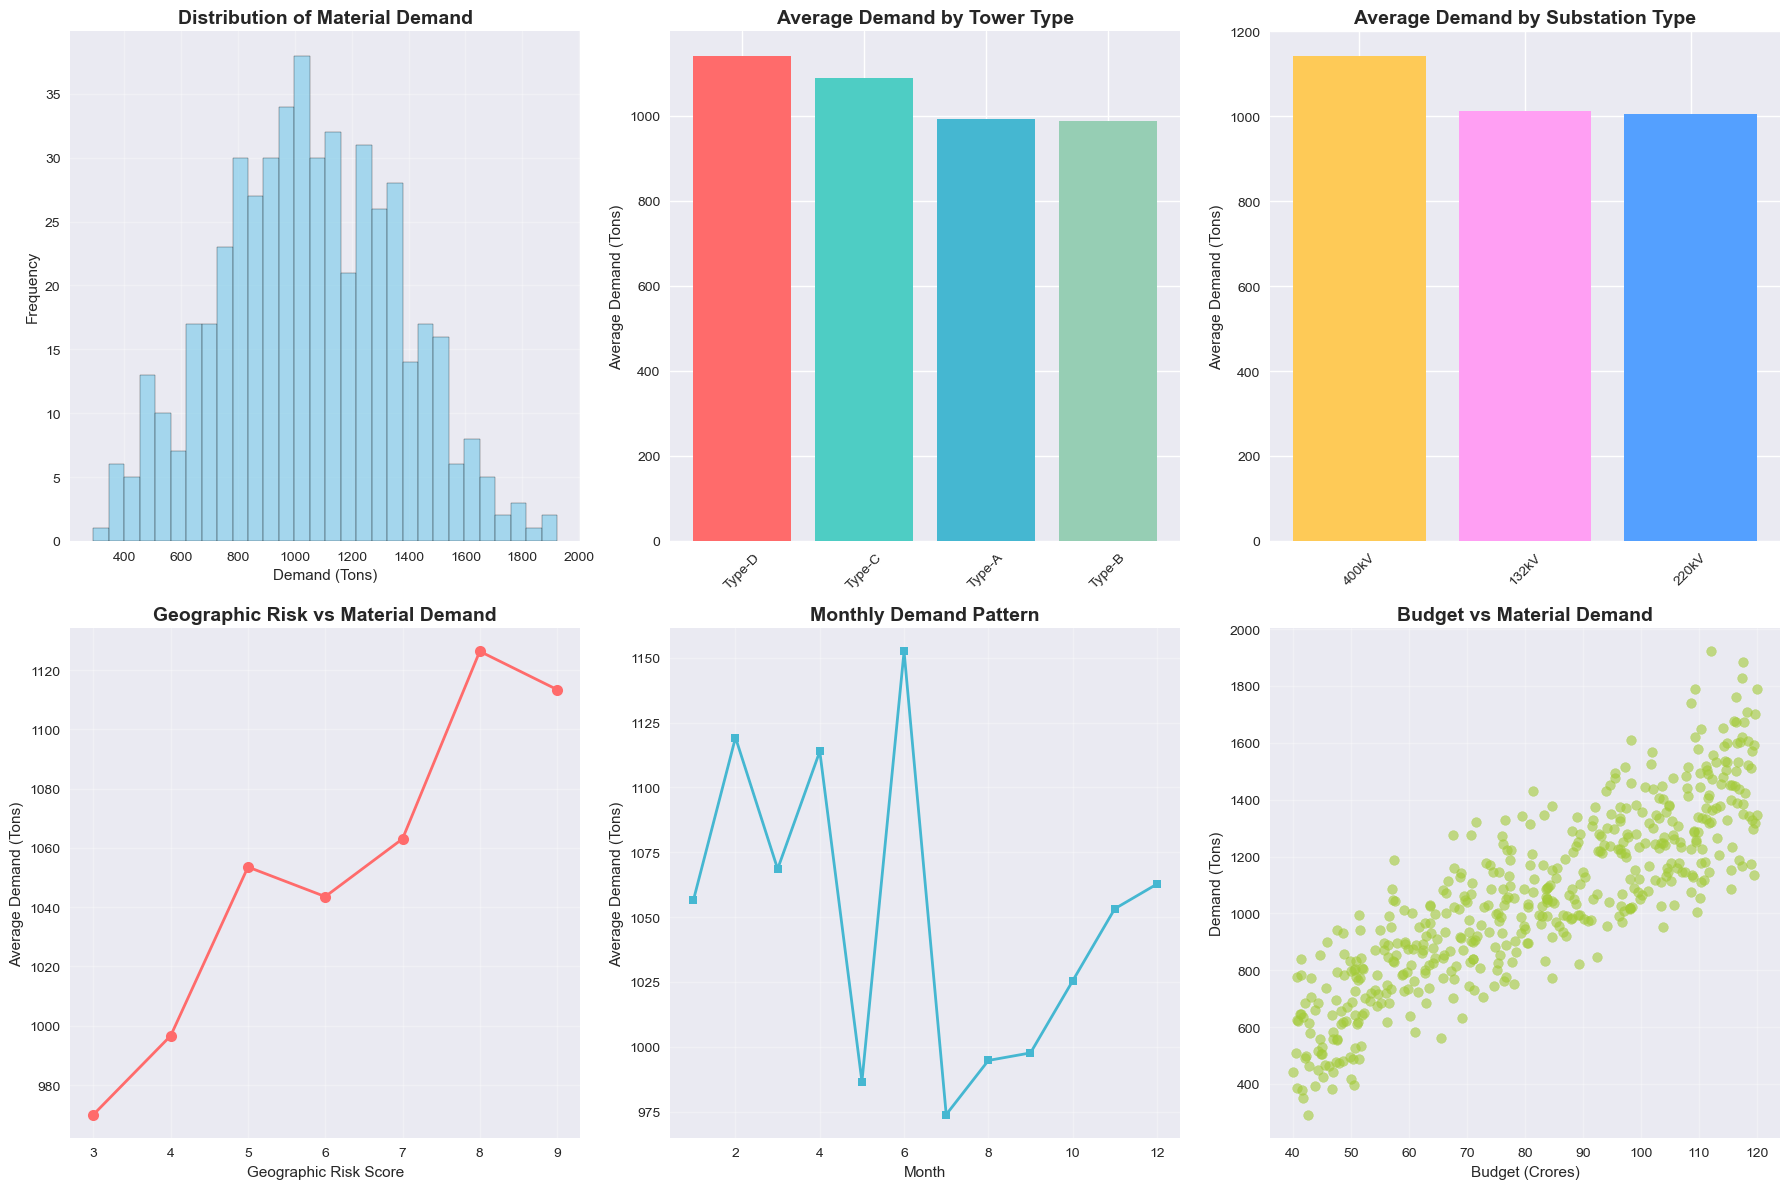

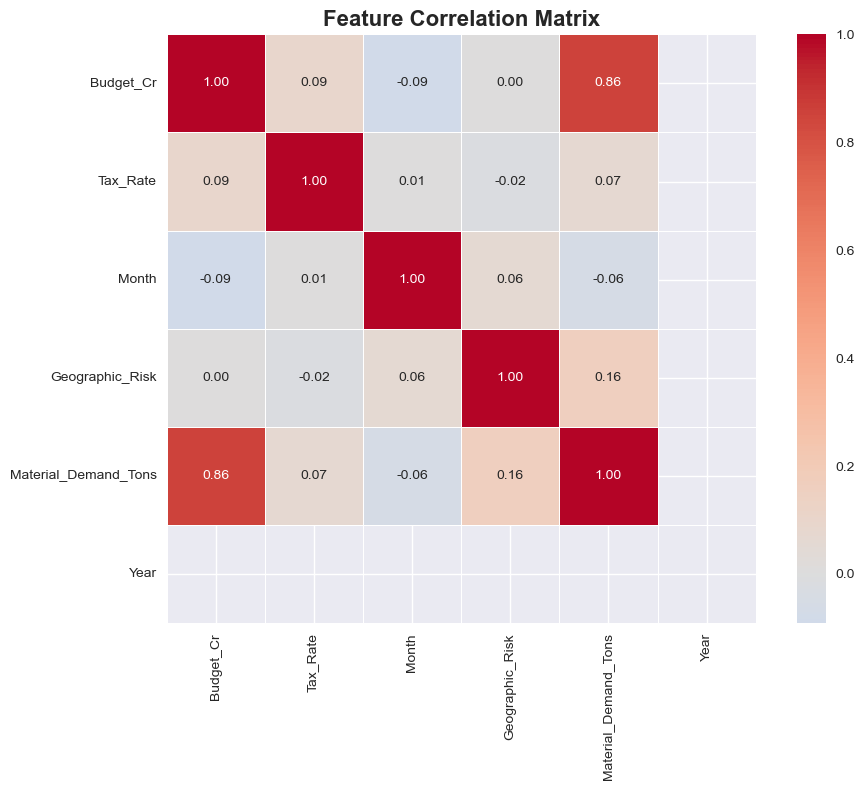

In [15]:
# Enhanced Data Analysis
print("\n🏢 Unique Values Analysis:")
print(f"Projects: {df['Project_ID'].nunique()}")
print(f"States: {df['State'].nunique()}") 
print(f"Tower Types: {df['Tower_Type'].unique()}")
print(f"Substation Types: {df['Substation_Type'].unique()}")
print(f"Months: {sorted(df['Month'].unique())}")
print(f"Years: {df['Year'].unique()}")

# Check the distribution of key variables
print(f"\n📊 Material Demand Statistics:")
print(f"Min Demand: {df['Material_Demand_Tons'].min()} tons")
print(f"Max Demand: {df['Material_Demand_Tons'].max()} tons")
print(f"Average Demand: {df['Material_Demand_Tons'].mean():.2f} tons")
print(f"Median Demand: {df['Material_Demand_Tons'].median():.2f} tons")

# Visualize the dataset
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Demand distribution
axes[0,0].hist(df['Material_Demand_Tons'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].set_title('Distribution of Material Demand', fontsize=14, fontweight='bold')
axes[0,0].set_xlabel('Demand (Tons)')
axes[0,0].set_ylabel('Frequency')
axes[0,0].grid(True, alpha=0.3)

# 2. Demand by Tower Type
tower_demand = df.groupby('Tower_Type')['Material_Demand_Tons'].mean().sort_values(ascending=False)
axes[0,1].bar(tower_demand.index, tower_demand.values, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])
axes[0,1].set_title('Average Demand by Tower Type', fontsize=14, fontweight='bold')
axes[0,1].set_ylabel('Average Demand (Tons)')
axes[0,1].tick_params(axis='x', rotation=45)

# 3. Demand by Substation Type
substation_demand = df.groupby('Substation_Type')['Material_Demand_Tons'].mean().sort_values(ascending=False)
axes[0,2].bar(substation_demand.index, substation_demand.values, color=['#FECA57', '#FF9FF3', '#54A0FF', '#00D2D3'])
axes[0,2].set_title('Average Demand by Substation Type', fontsize=14, fontweight='bold')
axes[0,2].set_ylabel('Average Demand (Tons)')
axes[0,2].tick_params(axis='x', rotation=45)

# 4. Geographic Risk vs Demand
risk_demand = df.groupby('Geographic_Risk')['Material_Demand_Tons'].mean()
axes[1,0].plot(risk_demand.index, risk_demand.values, marker='o', linewidth=2, markersize=8, color='#FF6B6B')
axes[1,0].set_title('Geographic Risk vs Material Demand', fontsize=14, fontweight='bold')
axes[1,0].set_xlabel('Geographic Risk Score')
axes[1,0].set_ylabel('Average Demand (Tons)')
axes[1,0].grid(True, alpha=0.3)

# 5. Monthly Demand Pattern
monthly_demand = df.groupby('Month')['Material_Demand_Tons'].mean()
axes[1,1].plot(monthly_demand.index, monthly_demand.values, marker='s', linewidth=2, markersize=6, color='#45B7D1')
axes[1,1].set_title('Monthly Demand Pattern', fontsize=14, fontweight='bold')
axes[1,1].set_xlabel('Month')
axes[1,1].set_ylabel('Average Demand (Tons)')
axes[1,1].grid(True, alpha=0.3)

# 6. Budget vs Demand scatter
axes[1,2].scatter(df['Budget_Cr'], df['Material_Demand_Tons'], alpha=0.6, color='#A3CB38')
axes[1,2].set_title('Budget vs Material Demand', fontsize=14, fontweight='bold')
axes[1,2].set_xlabel('Budget (Crores)')
axes[1,2].set_ylabel('Demand (Tons)')
axes[1,2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Correlation heatmap
plt.figure(figsize=(10, 8))
numeric_df = df.select_dtypes(include=[np.number])
correlation_matrix = numeric_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, fmt='.2f')
plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [17]:
print("🔧 Performing Feature Engineering...")

def engineer_features(df):
    df_processed = df.copy()
    
    # Ensure all numeric columns are properly typed
    numeric_cols = ['Budget_Cr', 'Tax_Rate', 'Geographic_Risk', 'Month']
    for col in numeric_cols:
        df_processed[col] = pd.to_numeric(df_processed[col], errors='coerce')
    
    # Create cyclical features for months - now with proper numeric types
    df_processed['Month_Sin'] = np.sin(2 * np.pi * df_processed['Month'] / 12)
    df_processed['Month_Cos'] = np.cos(2 * np.pi * df_processed['Month'] / 12)
    
    # Create interaction features
    df_processed['Budget_Risk_Interaction'] = df_processed['Budget_Cr'] * df_processed['Geographic_Risk']
    df_processed['Tax_Budget_Ratio'] = df_processed['Tax_Rate'] / df_processed['Budget_Cr']
    
    # Risk adjusted features
    df_processed['Risk_Adjusted_Budget'] = df_processed['Budget_Cr'] * (1 + df_processed['Geographic_Risk'] / 10)
    
    # Encode categorical variables
    label_encoders = {}
    categorical_columns = ['State', 'Tower_Type', 'Substation_Type']
    
    for col in categorical_columns:
        le = LabelEncoder()
        df_processed[col + '_Encoded'] = le.fit_transform(df_processed[col])
        label_encoders[col] = le
        print(f"Encoded {col}: {len(le.classes_)} categories")
    
    return df_processed, label_encoders

# Apply feature engineering
df_processed, label_encoders = engineer_features(df)

# Select features for modeling
feature_columns = [
    'Budget_Cr', 'Tax_Rate', 'Geographic_Risk', 
    'Month_Sin', 'Month_Cos', 
    'Budget_Risk_Interaction', 'Tax_Budget_Ratio', 'Risk_Adjusted_Budget',
    'State_Encoded', 'Tower_Type_Encoded', 'Substation_Type_Encoded'
]

X = df_processed[feature_columns]
y = df_processed['Material_Demand_Tons']

print(f"✅ Feature engineering completed. Using {len(feature_columns)} features:")
for feature in feature_columns:
    print(f"   - {feature}")

print(f"\n📊 Features shape: {X.shape}")
print(f"🎯 Target shape: {y.shape}")
print(f"\n✅ Feature data types:")
print(X.dtypes)

🔧 Performing Feature Engineering...
Encoded State: 10 categories
Encoded Tower_Type: 4 categories
Encoded Substation_Type: 3 categories
✅ Feature engineering completed. Using 11 features:
   - Budget_Cr
   - Tax_Rate
   - Geographic_Risk
   - Month_Sin
   - Month_Cos
   - Budget_Risk_Interaction
   - Tax_Budget_Ratio
   - Risk_Adjusted_Budget
   - State_Encoded
   - Tower_Type_Encoded
   - Substation_Type_Encoded

📊 Features shape: (500, 11)
🎯 Target shape: (500,)

✅ Feature data types:
Budget_Cr                  float64
Tax_Rate                     int64
Geographic_Risk              int64
Month_Sin                  float64
Month_Cos                  float64
Budget_Risk_Interaction    float64
Tax_Budget_Ratio           float64
Risk_Adjusted_Budget       float64
State_Encoded                int32
Tower_Type_Encoded           int32
Substation_Type_Encoded      int32
dtype: object


In [19]:
print("\n🤖 Building Random Forest Model...")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")

# Initialize and train Random Forest model
print("\n🏗️ Training Random Forest Regressor...")
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1  # Use all available cores
)

rf_model.fit(X_train, y_train)

print("✅ Random Forest model trained successfully!")

# Make predictions
y_pred = rf_model.predict(X_test)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Cross-validation scores
cv_scores = cross_val_score(rf_model, X, y, cv=5, scoring='r2')
cv_rmse_scores = cross_val_score(rf_model, X, y, cv=5, scoring='neg_mean_squared_error')
cv_rmse_scores = np.sqrt(-cv_rmse_scores)

print("\n📊 Model Performance Metrics:")
print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.2f} tons")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} tons")
print(f"Cross-Validation R²: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
print(f"Cross-Validation RMSE: {cv_rmse_scores.mean():.2f} ± {cv_rmse_scores.std():.2f} tons")

# Calculate percentage error
percentage_error = (rmse / y_test.mean()) * 100
print(f"Percentage Error: {percentage_error:.2f}% of average demand")


🤖 Building Random Forest Model...
Training set: 400 samples
Testing set: 100 samples

🏗️ Training Random Forest Regressor...
✅ Random Forest model trained successfully!

📊 Model Performance Metrics:
R² Score: 0.8206
Mean Absolute Error (MAE): 107.41 tons
Root Mean Squared Error (RMSE): 128.02 tons
Cross-Validation R²: 0.8125 ± 0.0267
Cross-Validation RMSE: 133.90 ± 18.57 tons
Percentage Error: 11.86% of average demand


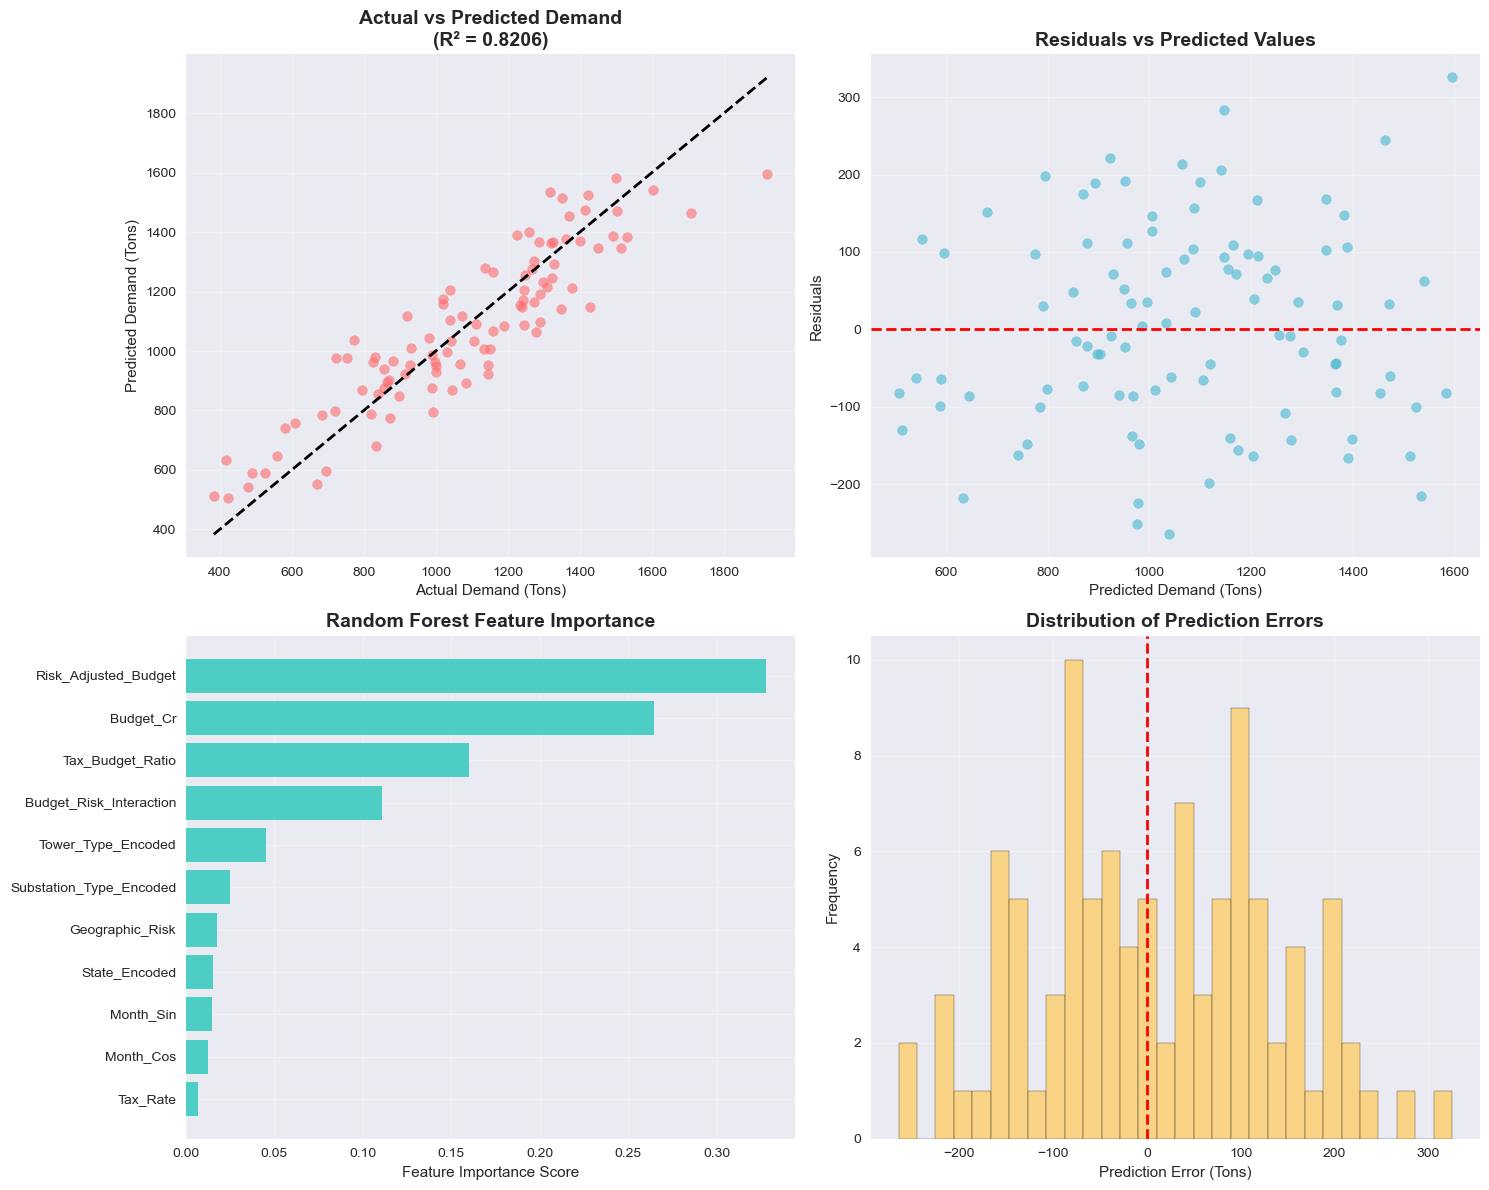


🔮 Testing Prediction Function:
Project Details: {'State': 'Tamil Nadu', 'Tower_Type': 'Type-B', 'Substation_Type': '400kV', 'Budget_Cr': 85.0, 'Tax_Rate': 18, 'Month': 6, 'Geographic_Risk': 7}
📦 Predicted Material Demand: 1081.04 tons


In [21]:
# Visualize model performance
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Actual vs Predicted
axes[0,0].scatter(y_test, y_pred, alpha=0.6, color='#FF6B6B')
axes[0,0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
axes[0,0].set_xlabel('Actual Demand (Tons)')
axes[0,0].set_ylabel('Predicted Demand (Tons)')
axes[0,0].set_title(f'Actual vs Predicted Demand\n(R² = {r2:.4f})', fontsize=14, fontweight='bold')
axes[0,0].grid(True, alpha=0.3)

# 2. Residuals plot
residuals = y_test - y_pred
axes[0,1].scatter(y_pred, residuals, alpha=0.6, color='#45B7D1')
axes[0,1].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[0,1].set_xlabel('Predicted Demand (Tons)')
axes[0,1].set_ylabel('Residuals')
axes[0,1].set_title('Residuals vs Predicted Values', fontsize=14, fontweight='bold')
axes[0,1].grid(True, alpha=0.3)

# 3. Feature Importance
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=True)

axes[1,0].barh(feature_importance['feature'], feature_importance['importance'], color='#4ECDC4')
axes[1,0].set_xlabel('Feature Importance Score')
axes[1,0].set_title('Random Forest Feature Importance', fontsize=14, fontweight='bold')
axes[1,0].grid(True, alpha=0.3)

# 4. Prediction error distribution
axes[1,1].hist(residuals, bins=30, alpha=0.7, color='#FECA57', edgecolor='black')
axes[1,1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1,1].set_xlabel('Prediction Error (Tons)')
axes[1,1].set_ylabel('Frequency')
axes[1,1].set_title('Distribution of Prediction Errors', fontsize=14, fontweight='bold')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Create prediction function
def predict_material_demand(model, input_features, label_encoders):
    """
    Predict material demand for new POWERGRID projects
    """
    # Create a copy of input features
    features = input_features.copy()
    
    # Convert numeric inputs
    features['Budget_Cr'] = float(features['Budget_Cr'])
    features['Tax_Rate'] = float(features['Tax_Rate'])
    features['Geographic_Risk'] = float(features['Geographic_Risk'])
    features['Month'] = int(features['Month'])
    
    # Feature engineering for new data
    features['Month_Sin'] = np.sin(2 * np.pi * features['Month'] / 12)
    features['Month_Cos'] = np.cos(2 * np.pi * features['Month'] / 12)
    features['Budget_Risk_Interaction'] = features['Budget_Cr'] * features['Geographic_Risk']
    features['Tax_Budget_Ratio'] = features['Tax_Rate'] / features['Budget_Cr']
    features['Risk_Adjusted_Budget'] = features['Budget_Cr'] * (1 + features['Geographic_Risk'] / 10)
    
    # Encode categorical variables
    for col in ['State', 'Tower_Type', 'Substation_Type']:
        le = label_encoders[col]
        if features[col] in le.classes_:
            features[col + '_Encoded'] = le.transform([features[col]])[0]
        else:
            # Handle unseen categories by using the most common class
            features[col + '_Encoded'] = 0
    
    # Prepare feature array in correct order
    feature_array = np.array([features[col] for col in feature_columns]).reshape(1, -1)
    
    # Make prediction
    prediction = model.predict(feature_array)[0]
    
    return prediction

# Test the prediction function
print("\n🔮 Testing Prediction Function:")
sample_project = {
    'State': 'Tamil Nadu',
    'Tower_Type': 'Type-B',
    'Substation_Type': '400kV',
    'Budget_Cr': 85.0,
    'Tax_Rate': 18,
    'Month': 6,
    'Geographic_Risk': 7
}

predicted_demand = predict_material_demand(rf_model, sample_project, label_encoders)
print(f"Project Details: {sample_project}")
print(f"📦 Predicted Material Demand: {predicted_demand:.2f} tons")